In [1]:
#This cell has the necessary code to retrieve a fasta sequence from the Uniprot website
def get_fasta(id):
    import urllib2 #importing the library
    import string
    import re
    url = "https://www.uniprot.org/uniprot/{0}.fasta".format(id) #importing the fasta sequence
    request = urllib2.Request(url) #Request
    response = urllib2.urlopen(request) #opening the request
    course = response.read() #reading the request
    regex = re.compile(r'^>([^\n\r]+)[\n\r]([A-Z\n\r]+)', re.MULTILINE) #reading the fasta sequence
    matches = [m.groups() for m in regex.finditer(course)]
    fasta1=matches[0][1]
    fasta=fasta1.replace("\n","")
    return fasta

In [2]:
fasta=get_fasta("O12342")

In [3]:
#This cell contains the code which reads the fasta sequence and assigns a position
#to the Amino acids and creates a text file.
#AA/tposition
file1=open('testfile.txt','w')
file1.write('AA\tPosition')
position=1
for r in fasta:
    file1.write('\n'+r+'\t'+str(position))
    position=position+1


#This cell code is used in the website to retrive the sequence for any uniprot ID

In [4]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Load pandas
import pandas as pd

# Load numpy
import numpy as np

#converting the text file into a table (Expasy_AA_Scales text file)
AA_label = pd.read_csv('/home/local/CORNELL/kg526/final_files/Expasy_AA_Scales.txt', sep='\t') 

#Changing the column name for future purpose
AA_labels=AA_label.rename(index=str, columns={"Amino Acid":"AA"})

path='/home/local/CORNELL/kg526/final_files/Training_Labels.txt'

#The below function assigns the Expasy AA Scale label to each Amino Acid in the sequence
#and assigns a position number to the AA
def read_protein(path):
    Protein_AA = pd.read_csv(path, sep='\t') 
    Protein_AA.insert(0, 'S.No', range(0, 0 + len(Protein_AA)))
    #Merging two tables
    Training_set_merge=pd.merge(Protein_AA, AA_labels, on="AA")
    Training_set=Training_set_merge.sort_values(by=['S.No'])
    return Training_set

In [5]:
#Extracting the label column from the Training Labels to list
label=read_protein(path)["Label"].tolist()
#Extracting the Amino Acid Sequence column to a list
AA_list = read_protein(path)["AA"].tolist()
#Extracting the Chou Fasman values for each Amino Acid in the sequence
Chou = read_protein(path)["alpha_helix__Chou_&_Fasman"].tolist()
#creating a list and assigning first 3 values as 0 as we are starting from position 3
#to retrieve the features
Chou_avg=[0,0,0] #list for Chou Fasman Avg values (Window size=5)
Choumin=[0,0,0] #list for min Chou Fasman values
i=3
while i < (len(Chou)-3):
    y=((Chou[i-2]+Chou[i-1]+Chou[i]+Chou[i+1]+Chou[i+2])/5)
    x=min(Chou[i-2],Chou[i-1],Chou[i], Chou[i+1], Chou[i+2])
    Chou_avg.append(y)
    Choumin.append(x)
    i=i+1
#new list to maintain the length of the list as we are starting from 3rd position.
r_5=[0,0,0] 
Chou_avg.extend(r_5)
Choumin.extend(r_5)

#Creating a dataframe Training to use it for training
Training=read_protein(path)[['Position', 'AA', 'Label']]

#Converting the list to series so that it can be added to the dataframe
Chou_avg = pd.Series(Chou_avg)
Choumin=pd.Series(Choumin)

#Adding the Chou Fasman Avg list and Min Chou Fasman list to the Training Data Frame
Training['Chou_avg']=Chou_avg.values
Training['Choumin']=Choumin.values

#Importing module to divide the Training labels into training list and testing list
from sklearn.model_selection import train_test_split

#The features used for training the classifier
X=Training[['Chou_avg', 'Choumin']]
y=Training['Label']

#Dividing the Training set into 80/20 Training/Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Setting the parameters for the classifier to optimise the performance
clf=RandomForestClassifier(n_estimators=50)

#fitting the data and training the classifier
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
#Taking the probable predicted values instead of predicted values
#For testing set
Test_Probs = clf.predict_proba(X_test)
Test_Probs = Test_Probs[:, 1]

#For Training set
Train_Probs=clf.predict_proba(X_train)
Train_Probs = Train_Probs[:, 1]

In [7]:
# First we will import the modules we want to use

# Sci-kit learn for machine learning
# (If you cannot import this, run the jupyter_restart script I provided
# several weeks ago with fresh=True)
from sklearn import tree

# For working with our data we will use numpy and pandas
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

# For plotting we will use matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
# Here are some methods that I stole to generate these curves

# Generates a ROC Curve for a given set of labels and scores
# - Accepts as parameters...
#   @labels - The label values
#   @scores - The predicted scores
#   @forcePosAUC - A boolean flag indicating whether scores should be inverted to maximize AUC
#                        (i.e. disallow an AUC < 0.50)
# - Returns the figure object, auc value, false positive rate, true positive rate, and
#    a boolean flad indicating whether or not scores were inverted
# - Written for general utility purposes 04/03/17 by Shayne Wierbowski
def plotROC(labels, scores, forcePosAUC=False):

    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    roc_auc = metrics.auc(fpr, tpr)

    inverted = False
    if(forcePosAUC and roc_auc < 0.5):
        fpr, tpr, _ = metrics.roc_curve(labels, -1*np.array(scores))
        roc_auc = auc(fpr, tpr)
        inverted = True

    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if(inverted):
        plt.title("Receiver Operating Characteristic (Inversed Score)")
    else:
        plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")

    if(forcePosAUC):
        return fig, roc_auc, fpr, tpr, inverted
    else:
        return fig, roc_auc, fpr, tpr
# FUNCTION END

# Generates a Precision Recall Curve for a given set of labels and scores
# - Accepts as parameters...
#   @labels - The label values
#   @scores - The predicted scores
# - Returns the figure object, auc value, precision, and recall
# - Written for general utility purposes 04/07/17 by Shayne Wierbowski
def plotPRC(labels, scores):
    # Compute Precision-Recall
    precision, recall, _ = metrics.precision_recall_curve(labels, scores)
    average_precision = metrics.average_precision_score(labels, scores)

    # Plot Precision-Recall curve
    fig = plt.figure()
    lw = 2
    plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")

    return fig, average_precision, precision, recall
# FUNCTION END

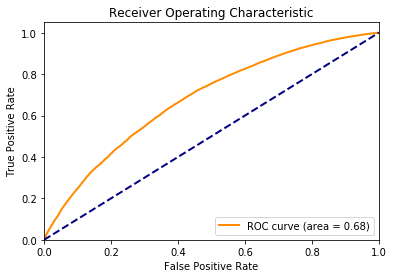

In [8]:
#Plotting a ROC Curve between testing set predicted values and Probable preducted values of testing set
plotROC(y_test, Test_Probs)
pass

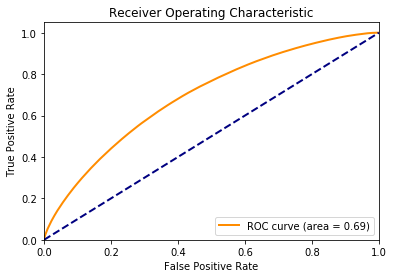

In [9]:
#Plotting a ROC Curve between training set predicted values and Probable preducted values of training set
plotROC(y_train, Train_Probs)
pass

In [10]:
import sklearn
#ROC AUC score
sklearn.metrics.roc_auc_score(y_train, Train_Probs) 

0.6943412464535738

In [11]:
#Dumping the trained classifier to be used in the website
from sklearn.externals import joblib
joblib.dump(clf, '/home/local/CORNELL/kg526/public_html/cgi-bin/final_clf.joblib' )

['/home/local/CORNELL/kg526/public_html/cgi-bin/final_clf.joblib']